## Jefferson Parish, LA 2023 Parish Council Election Results and Boundaries

### Sections
- <a href="#join">Read in Input Files and Join</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Datasets</a><br>

#### Sources

- [Louisiana Secretary of State - Jefferson Parish, LA 2023 Parish Council Election Returns](https://voterportal.sos.la.gov/Graphical)) 
- [Jefferson Parish, LA Parish Council Districts PDF](https://www.jeffparish.net/government/parish-council/map-of-parish-council-districts)
- [RDH - Louisiana 2022 General Election Precinct-Level Results and Boundaries](https://redistrictingdatahub.org/dataset/louisiana-2022-general-election-precinct-level-results/)

In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

######  RDH Function to Allocate Early Votes

In [2]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum(numeric_only=True))
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1
                            special_allocation_needed.append([race_district,race])
    if(len(special_allocation_needed) > 0):
        print("Special allocation used for", special_allocation_needed)

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum(numeric_only=True))

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

#### RDH Function to check vote totals

In [3]:
def county_totals_check(partner_df, partner_name, source_df, source_name, column_list, county_col, full_print=False, method="race"):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    
    if method == "race":
        diff_counties=[]
        for race in column_list:
            diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
            for val in diff[diff != 0].index.values.tolist():
                if val not in diff_counties:
                    diff_counties.append(val)
            if len(diff[diff != 0]!=0):   
                print(race + " contains differences in these counties:")
                for val in diff[diff != 0].index.values.tolist():
                    county_differences = diff[diff != 0]
                    print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                    print("\t\t"+ partner_name + ": "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                    print("\t\t"+ source_name +": "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
                if (full_print):
                    for val in diff[diff == 0].index.values.tolist():
                        county_similarities = diff[diff == 0]
                        print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
            else:
                print(race + " is equal across all counties")
                if (full_print):
                    for val in diff[diff == 0].index.values.tolist():
                        county_similarities = diff[diff == 0]
                        print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        if (len(diff_counties)>0):
            print()
            diff_counties.sort()
            print(diff_counties)
    elif method == "county":
        if set(source_df[county_col].unique()) != set(partner_df[county_col].unique()):
            raise ValueError("Not all counties will be checked")
        diff_counties=[]
        good_counties=[]
        holder_1 = partner_df.groupby(county_col).sum()
        holder_2 = source_df.groupby(county_col).sum()
        for county in list(partner_df[county_col].unique()):
            no_diff = True
            for race in column_list:
                partner_val = holder_1.loc[county][race]
                source_val =  holder_2.loc[county][race]
                diff = partner_val - source_val
                if diff != 0:
                    if no_diff:
                        print(f"{county} contains differences in these races:")
                        no_diff = False
                    print(f"\t{race} has a difference of {diff} vote(s)")
                    print(f"\t\t{partner_name}: {partner_val} vote(s)")
                    print(f"\t\t{source_name}: {source_val} vote(s)")
            if no_diff:
                good_counties.append(county)
            else:
                diff_counties.append(county)
        if (len(diff_counties)>0):
            print()
            diff_counties.sort()
            print(diff_counties)
        print("Counties that match:")
        if (len(good_counties)>0):
            print()
            good_counties.sort()
            print(good_counties)
    else:
        raise ValueError("Enter a correct method: race or county")

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from Louisiana SOS website to machine readable format, and checked for accuracy.

In [4]:
#Election Returns by precinct
er_raw = pd.read_csv("./raw-from-source/LA23_JEFFERSON_ER.csv").fillna(0)
#Add in Parish Column
er_raw['PARISH'] = 'Jefferson'
#Add in UNIQUE_ID columnn
er_raw['UNIQUE_ID'] = er_raw['PARISH'] + '-:-' + er_raw['PRECINCT']
er_raw.head()

,PRECINCT,DISTRICT,GCNCAARVRA,GCNCAARTEM,GCNCABRHYE,GCNCABRWAL,GCNCABRIMP,GCNC3DLEE,GCNC3DSHE,GCNC4RBOH,GCNC4RRIZ,GCNC4IMOR,GCNC5RLIL,GCNC5RBOU,PARISH,UNIQUE_ID
0,Total Votes,0.0,42214,37503,2657,50628,31732,6745.0,6244.0,8492.0,6130.0,1552.0,13205.0,6947.0,Jefferson,Jefferson-:-Total Votes
1,00 001,4.0,280,156,10,296,158,0.0,0.0,204.0,218.0,26.0,0.0,0.0,Jefferson,Jefferson-:-00 001
2,00 002,4.0,167,89,4,155,106,0.0,0.0,115.0,120.0,25.0,0.0,0.0,Jefferson,Jefferson-:-00 002
3,00 003,4.0,171,89,3,195,70,0.0,0.0,115.0,132.0,17.0,0.0,0.0,Jefferson,Jefferson-:-00 003
4,00 004,4.0,141,72,3,132,86,0.0,0.0,102.0,93.0,17.0,0.0,0.0,Jefferson,Jefferson-:-00 004


In [5]:
vote_cols = list(er_raw.columns[2:-2])
vote_cols

['GCNCAARVRA',
 'GCNCAARTEM',
 'GCNCABRHYE',
 'GCNCABRWAL',
 'GCNCABRIMP',
 'GCNC3DLEE',
 'GCNC3DSHE',
 'GCNC4RBOH',
 'GCNC4RRIZ',
 'GCNC4IMOR',
 'GCNC5RLIL',
 'GCNC5RBOU']

In [6]:
#make sure datatype is integer
er_raw[vote_cols] = er_raw[vote_cols].astype(int)

In [7]:
#split dataset in preparation for vote allocation
er_rec = er_raw.iloc[1:-1]
er_alloc = er_raw.iloc[-1:]
er_total = er_raw.iloc[:1]
er_rec

,PRECINCT,DISTRICT,GCNCAARVRA,GCNCAARTEM,GCNCABRHYE,GCNCABRWAL,GCNCABRIMP,GCNC3DLEE,GCNC3DSHE,GCNC4RBOH,GCNC4RRIZ,GCNC4IMOR,GCNC5RLIL,GCNC5RBOU,PARISH,UNIQUE_ID
1,00 001,4.0,280,156,10,296,158,0,0,204,218,26,0,0,Jefferson,Jefferson-:-00 001
2,00 002,4.0,167,89,4,155,106,0,0,115,120,25,0,0,Jefferson,Jefferson-:-00 002
3,00 003,4.0,171,89,3,195,70,0,0,115,132,17,0,0,Jefferson,Jefferson-:-00 003
4,00 004,4.0,141,72,3,132,86,0,0,102,93,17,0,0,Jefferson,Jefferson-:-00 004
5,00 005,4.0,139,89,4,154,77,0,0,91,123,12,0,0,Jefferson,Jefferson-:-00 005
6,00 007,4.0,128,65,14,137,75,0,0,101,85,28,0,0,Jefferson,Jefferson-:-00 007
7,00 008,4.0,100,66,7,111,62,0,0,82,71,17,0,0,Jefferson,Jefferson-:-00 008
8,00 009,4.0,103,58,6,95,74,0,0,70,76,29,0,0,Jefferson,Jefferson-:-00 009
9,00 010,4.0,106,84,4,121,75,0,0,83,92,15,0,0,Jefferson,Jefferson-:-00 010
10,00 011,4.0,130,72,8,129,88,0,0,90,100,27,0,0,Jefferson,Jefferson-:-00 011


##### Vote Allocation for Early Votes

In [8]:
er_final = allocate_absentee(er_rec,er_alloc,vote_cols,"PARISH",allocating_to_all_empty_precs=False)

### Vote Totals Check

In [9]:
county_totals_check(er_total, 'SOS', er_final, 'RDH', vote_cols, 'PARISH', full_print = False, method = "county")

***Countywide Totals Check***

Counties that match:

['Jefferson']


### Read in Precinct-Level Shapefile

In [10]:
# Read the shapefile in
la22 = gp.read_file("./raw-from-source/la_gen_2022_prec.shp")
jeff22 = la22[la22['Parish'] == 'Jefferson'][['UNIQUE_ID', 'Precinct', 'geometry']]

In [11]:
jeff22.head()

,UNIQUE_ID,Precinct,geometry
1344,Jefferson-:-00 001,00 001,"POLYGON ((-90.22551 30.02254, -90.22472 30.022..."
1345,Jefferson-:-00 002,00 002,"POLYGON ((-90.22143 30.02969, -90.22050 30.029..."
1346,Jefferson-:-00 003,00 003,"POLYGON ((-90.21950 30.03347, -90.21930 30.033..."
1347,Jefferson-:-00 004,00 004,"POLYGON ((-90.21597 30.02552, -90.21538 30.025..."
1348,Jefferson-:-00 005,00 005,"POLYGON ((-90.21465 30.02182, -90.21407 30.021..."


In [12]:
#Drop one row in shapefile that is not a precinct
jeff22 = jeff22[jeff22['Precinct'] != '0']

In [13]:
#Double check that precincts match
jeff_prec_22 = set(jeff22.UNIQUE_ID.unique())
jeff_prec_23 = set(er_final.UNIQUE_ID.unique())
jeff_prec_22 == jeff_prec_23

True

### Merge with Election Returns

In [14]:
# merge
jeff_pber = er_final.merge(jeff22, on='UNIQUE_ID', how = 'right', indicator=True)

In [15]:
#check indicator to see if merge was successful
jeff_pber._merge.value_counts()

both          273
left_only       0
right_only      0
Name: _merge, dtype: int64

In [16]:
#Drop merge column, drop district column
jeff_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [17]:
jeff_pber.head()

,PRECINCT,DISTRICT,GCNCAARVRA,GCNCAARTEM,GCNCABRHYE,GCNCABRWAL,GCNCABRIMP,GCNC3DLEE,GCNC3DSHE,GCNC4RBOH,GCNC4RRIZ,GCNC4IMOR,GCNC5RLIL,GCNC5RBOU,PARISH,UNIQUE_ID,Precinct,geometry
0,00 001,4.0,407,219,14,432,218,0,0,295,304,37,0,0,Jefferson,Jefferson-:-00 001,00 001,"POLYGON ((-90.22551 30.02254, -90.22472 30.022..."
1,00 002,4.0,243,125,5,226,146,0,0,167,167,36,0,0,Jefferson,Jefferson-:-00 002,00 002,"POLYGON ((-90.22143 30.02969, -90.22050 30.029..."
2,00 003,4.0,249,125,4,285,97,0,0,167,184,24,0,0,Jefferson,Jefferson-:-00 003,00 003,"POLYGON ((-90.21950 30.03347, -90.21930 30.033..."
3,00 004,4.0,205,101,4,193,119,0,0,148,130,24,0,0,Jefferson,Jefferson-:-00 004,00 004,"POLYGON ((-90.21597 30.02552, -90.21538 30.025..."
4,00 005,4.0,202,125,5,225,106,0,0,132,172,17,0,0,Jefferson,Jefferson-:-00 005,00 005,"POLYGON ((-90.21465 30.02182, -90.21407 30.021..."


In [18]:
#Rearrange columns
jeff_pber_final = jeff_pber[['UNIQUE_ID', 'PARISH', 'PRECINCT', 'DISTRICT'] + vote_cols + ['geometry']]
#fix
jeff_pber_final['DISTRICT'] = jeff_pber_final['DISTRICT'].astype(int)

<ipython-input-18-3f1b59d47bd7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_pber_final['DISTRICT'] = jeff_pber_final['DISTRICT'].astype(int)


In [19]:
jeff_pber_final.head()

,UNIQUE_ID,PARISH,PRECINCT,DISTRICT,GCNCAARVRA,GCNCAARTEM,GCNCABRHYE,GCNCABRWAL,GCNCABRIMP,GCNC3DLEE,GCNC3DSHE,GCNC4RBOH,GCNC4RRIZ,GCNC4IMOR,GCNC5RLIL,GCNC5RBOU,geometry
0,Jefferson-:-00 001,Jefferson,00 001,4,407,219,14,432,218,0,0,295,304,37,0,0,"POLYGON ((-90.22551 30.02254, -90.22472 30.022..."
1,Jefferson-:-00 002,Jefferson,00 002,4,243,125,5,226,146,0,0,167,167,36,0,0,"POLYGON ((-90.22143 30.02969, -90.22050 30.029..."
2,Jefferson-:-00 003,Jefferson,00 003,4,249,125,4,285,97,0,0,167,184,24,0,0,"POLYGON ((-90.21950 30.03347, -90.21930 30.033..."
3,Jefferson-:-00 004,Jefferson,00 004,4,205,101,4,193,119,0,0,148,130,24,0,0,"POLYGON ((-90.21597 30.02552, -90.21538 30.025..."
4,Jefferson-:-00 005,Jefferson,00 005,4,202,125,5,225,106,0,0,132,172,17,0,0,"POLYGON ((-90.21465 30.02182, -90.21407 30.021..."


In [20]:
#Geodf
jeff_pber_final = gp.GeoDataFrame(jeff_pber_final, geometry='geometry')
#check
type(jeff_pber_final)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

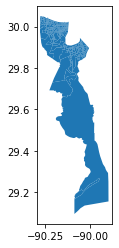

In [21]:
jeff_pber_final.plot()

### Parish District Shapefile

In [22]:
#dissolve
jeff_dist = jeff_pber_final[['DISTRICT', 'geometry']].dissolve(by='DISTRICT').reset_index()

In [23]:
#Add unique ID col
jeff_dist['DISTRICT'] = jeff_dist['DISTRICT'].astype(str)
jeff_dist['UNIQUE_ID'] = 'JEFFERSON_PARISHCOUNCIL_' + jeff_dist['DISTRICT']
#subset
jeff_dist = jeff_dist[['UNIQUE_ID', 'geometry']]

In [24]:
jeff_dist.head()

,UNIQUE_ID,geometry
0,JEFFERSON_PARISHCOUNCIL_1,"POLYGON ((-90.15575 29.66251, -90.15685 29.664..."
1,JEFFERSON_PARISHCOUNCIL_2,"POLYGON ((-90.21430 29.92628, -90.21480 29.926..."
2,JEFFERSON_PARISHCOUNCIL_3,"POLYGON ((-90.22155 29.93893, -90.21904 29.933..."
3,JEFFERSON_PARISHCOUNCIL_4,"POLYGON ((-90.25056 29.98210, -90.25044 29.982..."
4,JEFFERSON_PARISHCOUNCIL_5,"POLYGON ((-90.16711 29.97522, -90.16947 29.975..."


<AxesSubplot:>

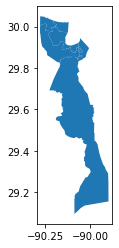

In [25]:
jeff_dist.plot()



<p><a name="exp"></a></p>

### Export Cleaned Datasets

In [26]:
if not os.path.exists("./LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER"):
    os.mkdir("./LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER")

jeff_dist.to_file("./LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER/LA23_JEFFERSON_DIST.shp")    
jeff_pber_final.to_file("./LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER.shp")

In [27]:
def check_file(path):
    if ".csv" in path:
        file_type = ".csv"
        load = pd.read_csv(path)
    elif ".shp" in path:
        file_type = ".shp"
        load = gp.read_file(path)
        assert(os.path.exists(path[0:-4] + ".cpg"))
        assert(os.path.exists(path[0:-4] + ".dbf"))
        assert(os.path.exists(path[0:-4] + ".prj"))
        assert(os.path.exists(path[0:-4] + ".shx"))
    else:
        raise ValueError ("Other function needed to load non .csv or .shp")
    run_checks(load, path, file_type)
    
def run_checks(file, path, file_type):
    if "/Users" in path:
        path = path.replace("/Users","")
    path_name = path.replace("/","-")
    
        
    with open("./FILE_CHECK" + path_name + ".txt","w") as t:
        t.write("***RDH FILE CHECKER***\n")
        t.write("Checking file located at " + path+"\n")
        t.write("\n")
        t.write("\n")        
        
        t.write("***N/A VALUES***\n")
        if(file.isna().any().sum() != 0):
            t.write("N/A values in the following columns\n")
            for col in file.columns:
                num_nas = file[col].isna().sum()
                string_nans = file[file[col]=="nan"].shape[0]
                if file[col].isna().any().sum():
                    t.write("\t"+col+" - "+ str(num_nas) +" row(s)\n")
                elif  string_nans > 0:
                    t.write("\t"+col+" - "+ str(string_nans) +" row(s)\n")

        else:
            t.write("Do not appear to be N/A values")
        t.write("\n")
        t.write("\n")
        
        t.write("***File Size***\n")
        t.write("File contains " + str(file.shape[0]) + " row(s)\n")
        t.write("File contains " + str(file.shape[1]) + " column(s)\n")
        t.write("\n")
        t.write("\n")
        
        if file_type == ".shp":
            t.write("***Invalid Geometries***\n")
            t.write("File contains " + str(file[~file["geometry"].is_valid].shape[0]) + " invalid GEOM row(s)\n")
            t.write("File contains " + str(file[file["geometry"].is_valid].shape[0]) + " valid GEOM row(s)\n")
            t.write("\n")
            t.write("\n")

        t.write("***COLUMN NAMES***\n")
        t.write(str(list(file.columns)))
        t.write("\n")
        t.write("\n")
        
        t.write("***COLUMN NAME LENGTHS***\n")
        long_col_name_list = [i for i in file.columns if len(i) > 10]
        if len(long_col_name_list) > 0:
            t.write("The following columns are longer than 10 characters:" + str(long_col_name_list)+"\n")
        else:
            t.write("No column names are longer than 10 characters\n")
        t.write("\n")
        t.write("\n")

        t.write("***FULL FILE SUMMARY***\n")
        t.write(str(file.describe())+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***MAX VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.max()) + "\n")
        t.write("\n")
        t.write("\n")

        t.write("***MIN VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.min()) + "\n")
        t.write("\n")
        
        t.write("***NUMERIC COLUMN SUMS***\n")
        t.write(str(file.sum(numeric_only=True))+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***COLUMNS AND DUPLICATE VALUES***\n")
        for col in list(file.columns):
            if col != "geometry":
                if max(file[col].value_counts(dropna = False))==1:
                    t.write("NO: Column " + col + " DOES NOT HAVE duplicate values\n")
                elif max(file[col].value_counts(dropna = False))>1:
                    t.write("YES: Column " + col+ " HAS duplicate values\n")
        t.write("\n")


In [28]:
check_file("./LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER/LA23_JEFFERSON_PBER.shp")